/jobfs/144320707.gadi-pbs/ipykernel_862717/3702976641.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_region = stations_gdf[stations_gdf.within(region.unary_union)].reset_index(drop=True)


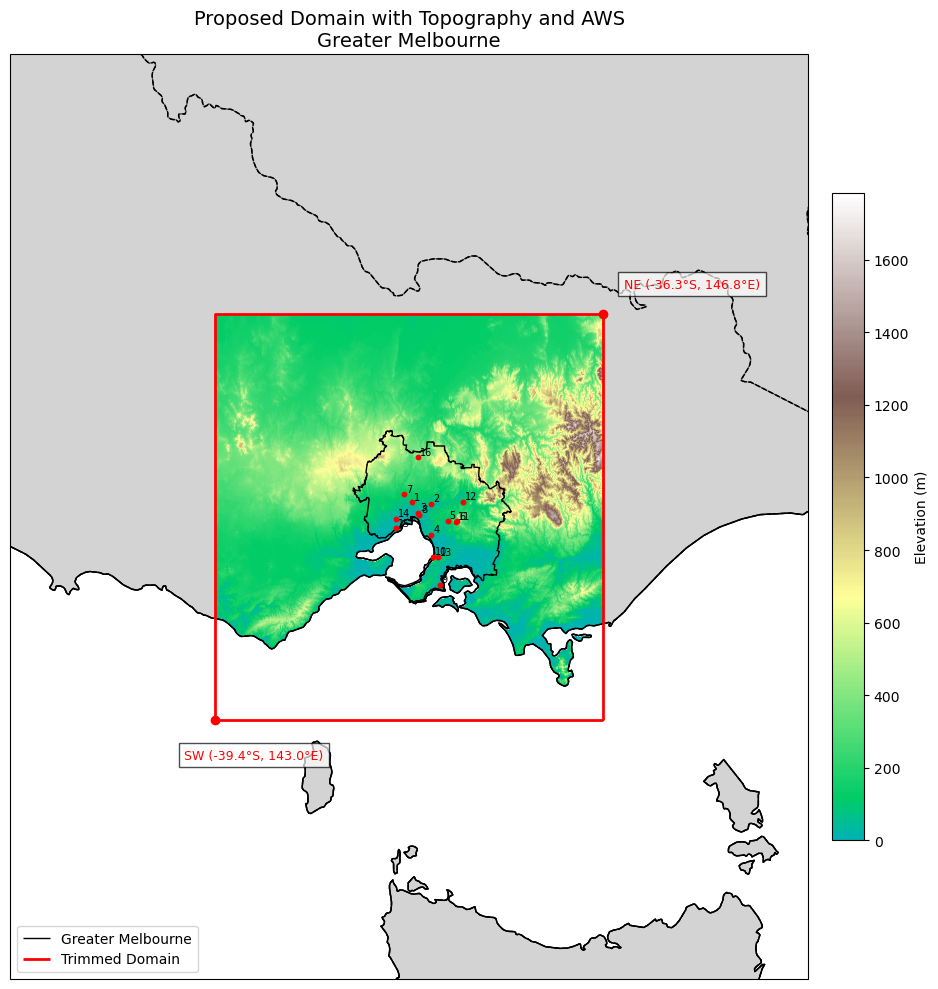

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import box
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.features import geometry_mask
from matplotlib import colors

# === File paths ===
file_path     = '/g/data/w28/yk8692/nesp'
tif_path      = '/g/data/w28/yk8692/nesp/figure/minimum_domains/srtm-1sec-dem-v1-COG.tif'
shp_path      = "/g/data/w28/yk8692/nesp/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
station_path  = "/g/data/w28/yk8692/nesp/station/All_stations_information.xlsx"
region_name   = "Greater Melbourne"

# === Load shapefile and filter region ===
gccsa = gpd.read_file(shp_path).to_crs(epsg=4326)
region = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)]
minx, miny, maxx, maxy = region.total_bounds

# === Load and filter AWS stations ===
stations_df = pd.read_excel(station_path, engine='openpyxl')
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['Longitude'], stations_df['Latitude']),
    crs='EPSG:4326'
)
stations_in_region = stations_gdf[stations_gdf.within(region.unary_union)].reset_index(drop=True)
stations_in_region["Index"] = range(1, len(stations_in_region) + 1)

# === Create directional buffer box ===
buffer_km = {"W": 150, "E": 100, "S": 100, "N": 100}
deg_per_km = 1 / 111.0
west  = minx - buffer_km["W"] * deg_per_km
east  = maxx + buffer_km["E"] * deg_per_km
south = miny - buffer_km["S"] * deg_per_km
north = maxy + buffer_km["N"] * deg_per_km
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs="EPSG:4326")

# === Read full raster in bounding box ===
with rasterio.open(tif_path) as src:
    window = src.window(west, south, east, north)
    transform = src.window_transform(window)
    elevation = src.read(1, window=window).astype(float)
    nodata = src.nodata
    if nodata is not None:
        elevation[elevation == nodata] = np.nan
    else:
        elevation[elevation > 1e5] = np.nan

    # === Calculate extent for the DEM image ===
    extent = [
        transform[2],
        transform[2] + transform[0] * elevation.shape[1],
        transform[5] + transform[4] * elevation.shape[0],
        transform[5]
    ]
# === Create land mask from Natural Earth land polygons ===
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    land_shapes = list(land.geometries())
    land_mask = geometry_mask(
        [g for g in land_shapes],
        transform=transform,
        invert=True,
        out_shape=elevation.shape
    )
    elevation[~land_mask] = np.nan  # Mask ocean area

# === Plot ===
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Wider extent around the domain
extra_deg = 2.0
ax.set_extent([west - extra_deg, east + extra_deg, south - extra_deg, north + extra_deg], crs=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')

terrain = plt.get_cmap('terrain')
new_terrain = colors.LinearSegmentedColormap.from_list(
    "modified_terrain", terrain(np.linspace(0.20, 1, 256))  # skip blue
)
# Plot DEM only over land
im = ax.imshow(
    elevation,
    cmap=new_terrain,
    extent=extent,
    origin='upper',
    vmin=0,
    transform=ccrs.PlateCarree()
)

# Region boundary
region.boundary.plot(ax=ax, edgecolor='k', linewidth=1, transform=ccrs.PlateCarree(), label=region_name)

# Red domain box
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label="Trimmed Domain")

# Corner labels
sw_lon, sw_lat, ne_lon, ne_lat = domain_box.bounds
ax.plot(sw_lon, sw_lat, 'ro', transform=ccrs.PlateCarree())
ax.plot(ne_lon, ne_lat, 'ro', transform=ccrs.PlateCarree())
ax.text(sw_lon - 0.3, sw_lat - 0.3, f"SW ({sw_lat:.1f}°S, {sw_lon:.1f}°E)", fontsize=9, color='red',
        transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7))
ax.text(ne_lon + 0.2, ne_lat + 0.2, f"NE ({ne_lat:.1f}°S, {ne_lon:.1f}°E)", fontsize=9, color='red',
        transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7))

# AWS station points
stations_in_region.plot(ax=ax, color='red', markersize=10, zorder=3, transform=ccrs.PlateCarree())
for i, row in stations_in_region.iterrows():
    ax.text(
        row.geometry.x + 0.02,
        row.geometry.y + 0.02,
        str(row["Index"]),
        fontsize=7,
        color="black",
        transform=ccrs.PlateCarree()
    )

# Final labels
ax.set_title(f"Proposed Domain with Topography and AWS\n{region_name}", fontsize=14)
plt.colorbar(im, ax=ax, label="Elevation (m)", shrink=0.7, pad=0.02)
ax.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f"{file_path}/figure/{region_name}_aws_topo_domain_map.png", dpi=300, bbox_inches='tight')

plt.show()


In [2]:
import geopandas as gpd
import numpy as np

# Load buffered Auckland domain
buffer_shp = "/g/data/w28/yk8692/nesp/statsnz-territorial-authority-2025-clipped-SH_auckland_buffer-km-100_wgs84_env.shp"
buffer_gdf = gpd.read_file(buffer_shp)

# Get bounding box
minx, miny, maxx, maxy = buffer_gdf.total_bounds

# Round for display
sw_lat, sw_lon = round(miny, 1), round(minx, 1)
ne_lat, ne_lon = round(maxy, 1), round(maxx, 1)

# Create grid centre coordinates
lat_centres = np.arange(miny + 0.005, maxy, 0.01)
lon_centres = np.arange(minx + 0.005, maxx, 0.01)

lat_range = f"{round(lat_centres[0], 3)}° to {round(lat_centres[-1], 3)}°"
lon_range = f"{round(lon_centres[0], 3)}° to {round(lon_centres[-1], 3)}°"

# Output summary
print(f"SW Corner: {sw_lat}°S, {sw_lon}°E")
print(f"NE Corner: {ne_lat}°S, {ne_lon}°E")
print(f"Grid Cell Centre Latitudes: {lat_range}")
print(f"Grid Cell Centre Longitudes: {lon_range}")


SW Corner: -38.2°S, 173.0°E
NE Corner: -35.0°S, 176.7°E
Grid Cell Centre Latitudes: -38.189° to -34.999°
Grid Cell Centre Longitudes: 173.051° to 176.661°
